In [1]:
!pip uninstall -y torch torchvision torchaudio


!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu118
!pip install transformers==4.41.0

!wget https://github.com/state-spaces/mamba/releases/download/v2.2.2/mamba_ssm-2.2.2+cu122torch2.3cxx11abiFALSE-cp311-cp311-linux_x86_64.whl

!pip install mamba_ssm-2.2.2+cu122torch2.3cxx11abiFALSE-cp311-cp311-linux_x86_64.whl

!pip install causal-conv1d>=1.4.0

import torch
print("PyTorch:", torch.__version__)  # e.g., 2.1.0+cu121
print("CUDA:", torch.version.cuda)    # e.g., 12.1
!python --version   

import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from mamba_ssm import Mamba
from torch.optim import Adam
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import GPT2Tokenizer
from mamba_ssm.models.mixer_seq_simple import MixerModel
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
from transformers import AutoModelForCausalLM
from mamba_ssm.models.config_mamba import MambaConfig

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.7/839.7 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 2.4 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 79.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 61.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 76.9 MB/s eta 0:00:0000:0100:01
    

✅ Original Data:
📐 Shape: (619040, 7)
🧾 Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'Name']

🔍 Sample Data:
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
AAPL Stock Data Shape before: (1259, 6)
Dataset sizes:
Training: 877 sequences
Validation: 188 sequences
Testing: 189 sequences
torch.Size([16, 5, 5])


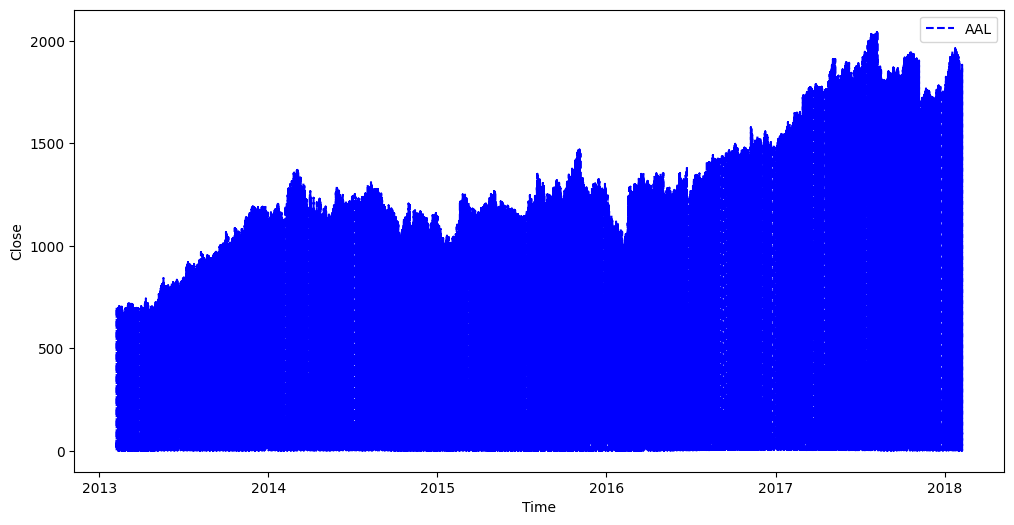

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pylab as plt
df = pd.read_csv('/kaggle/input/sandp500/all_stocks_5yr.csv')
    
print("✅ Original Data:")
print(f"📐 Shape: {df.shape}")
print(f"🧾 Columns: {df.columns.tolist()}")
print("\n🔍 Sample Data:")
print(df.head())

# Drop rows with missing values (if any)
df = df.dropna()

# Convert and sort by date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

aapl_df = df[df['Name'] == 'AAL'].copy()
aapl_df.set_index('date', inplace=True)  # Set date as index for time-based operations
print(f"AAPL Stock Data Shape before: {aapl_df.shape}")
#print(aapl_df.head())
df.describe()


# Select features and target
feature_cols = ['open', 'high', 'low', 'close', 'volume']
target_col = 'close'

features = aapl_df[feature_cols].values.astype(np.float32)
target = aapl_df[target_col].values.astype(np.float32)

# Normalize features and target separately
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

# Create sequences with multiple features
def create_sequences(features, target, seq_length, pred_length):
    X, y = [], []
    for i in range(len(features) - seq_length - pred_length + 1):
        X.append(features[i:i+seq_length])  # Shape: (seq_length, num_features)
        y.append(target[i+seq_length:i+seq_length+pred_length])  # Shape: (pred_length,)
    return np.array(X), np.array(y)

SEQ_LENGTH = 5
PRED_LENGTH = 1

X, y = create_sequences(scaled_features, scaled_target, SEQ_LENGTH, PRED_LENGTH)
total_size = len(X)
train_size = int(0.7 * total_size)  # 60% training
val_size = int(0.15 * total_size)    # 20% validation
# test_size = total_size - train_size - val_size (remaining 20%)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Dataset sizes:")
print(f"Training: {X_train.shape[0]} sequences")
print(f"Validation: {X_val.shape[0]} sequences")
print(f"Testing: {X_test.shape[0]} sequences")

X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

# Create DataLoaders
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

for batch in train_loader:
    print(batch[0].shape)  # for a single tensor
    break
plt.figure(figsize=(12, 6))
plt.plot(df['date'],df['close'],'--b',label="AAL")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Close')
plt.show()

In [4]:
class SeriesDecomposition(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.avg_pool = nn.AvgPool1d(kernel_size, stride=1, padding=0)
        
    def forward(self, x):
        # Pad manually with replication
        x_perm = x.permute(0, 2, 1)
        x_padded = torch.nn.functional.pad(
            x_perm, 
            (self.padding, self.padding), 
            mode='replicate'
        )
        
        # Apply pooling
        trend = self.avg_pool(x_padded)
        trend = trend.permute(0, 2, 1)
        
        seasonal = x - trend
        return seasonal, trend

In [6]:
import torch
import torch.nn as nn
import torch.fft as fft
from einops import rearrange
class AutoCorrelation(nn.Module):
    """Fixed Auto-Correlation Mechanism with FFT optimization"""
    def __init__(self, d_model, n_heads, causal=False, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.causal = causal
        self.dropout = nn.Dropout(dropout)
        
        # Projections for Q, K, V
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    def time_delay_agg(self, q, k, v):
        """Fixed FFT-based time delay aggregation"""
        batch, heads, seq_len, d_head = q.shape
        
        # Compute autocorrelation via FFT
        q_fft = torch.fft.rfft(q, dim=-1)
        k_fft = torch.fft.rfft(k, dim=-1)
        corr = torch.fft.irfft(q_fft * torch.conj(k_fft), dim=-1)
        
        # Top-k time delays
        top_k = min(seq_len, 5)  # Autoformer uses top-k delays
        top_vals, top_delays = torch.topk(corr, top_k, dim=-1)
        
        # Causal masking for decoder
        if self.causal:
            mask = torch.ones_like(top_vals) * float('-inf')
            mask = mask.triu(diagonal=1)  # Upper triangular mask
            top_vals = top_vals + mask
        
        # Softmax over delays
        attn = torch.softmax(top_vals, dim=-1)
        
        # Aggregate values with time delays using gather
        batch_indices = torch.arange(batch,device='cuda').view(batch, 1, 1, 1)
        head_indices = torch.arange(heads,device='cuda').view(1, heads, 1, 1)
        seq_indices = torch.arange(seq_len,device='cuda').view(1, 1, seq_len, 1)
        
        agg = torch.zeros_like(v)
        for i in range(top_k):
            # Calculate shifted indices
            shift = top_delays[..., i]
            shifted_indices = (seq_indices - shift.unsqueeze(-1)) % seq_len
            
            # Gather shifted values
            shifted_indices = shifted_indices.expand(-1, -1, -1, d_head).long()
            rolled = torch.gather(v, 2, shifted_indices)
            
            # Weighted aggregation
            agg = agg + attn[..., i].unsqueeze(-1) * rolled
        
        return agg

    def forward(self, q, k, v):
        # Project inputs
        q = rearrange(self.Wq(q), 'b l (h d) -> b h l d', h=self.n_heads)
        k = rearrange(self.Wk(k), 'b l (h d) -> b h l d', h=self.n_heads)
        v = rearrange(self.Wv(v), 'b l (h d) -> b h l d', h=self.n_heads)
        
        # Auto-correlation
        out = self.time_delay_agg(q, k, v)
        out = rearrange(out, 'b h l d -> b l (h d)')
        return self.out_proj(out)

class ConvFFN(nn.Module):
    """Convolutional Feed-Forward Network (Autoformer style)"""
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(d_model, d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(d_ff, d_model, kernel_size=1)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x):
        x = x.transpose(1, 2)  # [B, D, L]
        x = self.conv1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = x.transpose(1, 2)  # [B, L, D]
        return x

In [7]:
class AutoformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, kernel_size, dropout=0.1):
        super().__init__()
        self.auto_corr = AutoCorrelation(d_model, n_heads, causal=False, dropout=dropout)
        self.conv_ffn = ConvFFN(d_model, d_ff, dropout)
        self.decomp = SeriesDecomposition(kernel_size)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, seasonal_in, trend_in):
        # Auto-Correlation Block
        attn_out = self.auto_corr(seasonal_in, seasonal_in, seasonal_in)
        seasonal_attn = seasonal_in + self.dropout(attn_out)
        seasonal_attn = self.norm1(seasonal_attn)
        
        # Convolutional FFN
        ffn_out = self.conv_ffn(seasonal_attn)
        seasonal_ffn = seasonal_attn + self.dropout(ffn_out)
        seasonal_ffn = self.norm2(seasonal_ffn)
        
        # Series Decomposition
        seasonal_decomp, trend_update = self.decomp(seasonal_ffn)
        trend_out = trend_in + trend_update
        
        return seasonal_decomp, trend_out

class AutoformerEncoder(nn.Module):
    def __init__(self, input_features=5, d_model=64, n_layer=2, 
                 n_heads=4, d_ff=256, kernel_size=3, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_features, d_model)
        self.init_decomp = SeriesDecomposition(kernel_size)
        self.trend_proj = nn.Linear(d_model, 1)
        self.layers = nn.ModuleList([
            AutoformerEncoderLayer(
                d_model=d_model, 
                n_heads=n_heads,
                d_ff=d_ff,
                kernel_size=kernel_size,
                dropout=dropout
            ) for _ in range(n_layer)
        ])
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        x = self.input_proj(x)
        seasonal, trend = self.init_decomp(x)
        for layer in self.layers:
            seasonal, trend = layer(seasonal, trend)
        return seasonal, trend



In [8]:
class AutoformerDecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, kernel_size, dropout=0.1):
        super().__init__()
        self.self_auto_corr = AutoCorrelation(d_model, n_heads, causal=True, dropout=dropout)
        self.cross_auto_corr = AutoCorrelation(d_model, n_heads, causal=False, dropout=dropout)
        self.conv_ffn = ConvFFN(d_model, d_ff, dropout)
        self.decomp = SeriesDecomposition(kernel_size)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, target_seasonal, enc_seasonal, enc_trend):
        # Self Auto-Correlation (Causal)
        self_attn = self.self_auto_corr(target_seasonal, target_seasonal, target_seasonal)
        target_self = target_seasonal + self.dropout(self_attn)
        target_self = self.norm1(target_self)
        
        # Cross Auto-Correlation
        cross_attn = self.cross_auto_corr(target_self, enc_seasonal, enc_seasonal)
        target_cross = target_self + self.dropout(cross_attn)
        target_cross = self.norm2(target_cross)
        
        # Convolutional FFN
        ffn_out = self.conv_ffn(target_cross)
        target_ffn = target_cross + self.dropout(ffn_out)
        target_ffn = self.norm3(target_ffn)
        
        # Series Decomposition
        seasonal_decomp, trend_update = self.decomp(target_ffn)
        return seasonal_decomp, trend_update

class AutoformerDecoder(nn.Module):
    def __init__(self, d_model=64, n_heads=4, d_ff=256, n_layer=2, 
                 kernel_size=3, dropout=0.1, input_dim=1, output_dim=1, pred_length=1):
        super().__init__()
        self.pred_length = pred_length
        self.input_proj = nn.Linear(input_dim, d_model)
        self.trend_init = nn.Linear(d_model, d_model)
        self.layers = nn.ModuleList([
            AutoformerDecoderLayer(
                d_model=d_model,
                n_heads=n_heads,
                d_ff=d_ff,
                kernel_size=kernel_size,
                dropout=dropout
            ) for _ in range(n_layer)
        ])
        self.seasonal_head = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, output_dim)
        )
        self.trend_head = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, output_dim)
        )
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p, gain=nn.init.calculate_gain('relu'))

    def forward(self, target, enc_seasonal, enc_trend):
        # Initialize seasonal and trend components
        seasonal = self.input_proj(target)
        
        # Only need one step for next-day prediction
        last_trend = enc_trend[:, -1:, :]
        trend = self.trend_init(last_trend)  # [batch, 1, d_model]
        
        # Process through decoder layers
        for layer in self.layers:
            seasonal, trend_update = layer(seasonal, enc_seasonal, enc_trend)
            trend = trend + trend_update
        
        seasonal_pred = self.seasonal_head(seasonal[:, :1, :])  
        trend_pred = self.trend_head(trend[:, :1, :])          
        return seasonal_pred + trend_pred

In [9]:
class Model(nn.Module):
    def __init__(self, input_features=5, d_model=64, pred_length=1):
        super().__init__()
        self.encoder = AutoformerEncoder(input_features, d_model)
        self.decoder = AutoformerDecoder(
            d_model=d_model,
            pred_length=pred_length,
            input_dim=1  # Close price only
        )
        self.pred_length = pred_length

    def forward(self, src):
        # 1. Encode source
        enc_seasonal, enc_trend = self.encoder(src)
        
        decoder_input = torch.zeros(
            src.size(0), 
            self.pred_length, 
            1,
            device=src.device
        )
        decoder_input = src[:, -1:, 3:4]
        
        # 3. Decode
        predictions = self.decoder(
            decoder_input, 
            enc_seasonal, 
            enc_trend
        )
        return predictions.squeeze(-1)

model = Model().to('cuda')

Epoch 1/20: 100%|██████████| 12/12 [00:00<00:00, 84.44it/s]


Epoch 1: Train Loss=0.0347, Val Loss=0.0231, Val RMSE=0.2149
-> Saved Best Model


Epoch 2/20: 100%|██████████| 12/12 [00:00<00:00, 75.07it/s]


Epoch 2: Train Loss=0.0295, Val Loss=0.0227, Val RMSE=0.2129
-> Saved Best Model


Epoch 3/20: 100%|██████████| 12/12 [00:00<00:00, 89.65it/s]


Epoch 3: Train Loss=0.0163, Val Loss=0.0103, Val RMSE=0.1433
-> Saved Best Model


Epoch 4/20: 100%|██████████| 12/12 [00:00<00:00, 86.74it/s]


Epoch 4: Train Loss=0.0150, Val Loss=0.0231, Val RMSE=0.2141


Epoch 5/20: 100%|██████████| 12/12 [00:00<00:00, 89.52it/s]


Epoch 5: Train Loss=0.0253, Val Loss=0.0089, Val RMSE=0.1331
-> Saved Best Model


Epoch 6/20: 100%|██████████| 12/12 [00:00<00:00, 84.14it/s]


Epoch 6: Train Loss=0.0177, Val Loss=0.0125, Val RMSE=0.1573


Epoch 7/20: 100%|██████████| 12/12 [00:00<00:00, 87.30it/s]


Epoch 7: Train Loss=0.0142, Val Loss=0.0077, Val RMSE=0.1243
-> Saved Best Model


Epoch 8/20: 100%|██████████| 12/12 [00:00<00:00, 85.91it/s]


Epoch 8: Train Loss=0.0118, Val Loss=0.0068, Val RMSE=0.1150
-> Saved Best Model


Epoch 9/20: 100%|██████████| 12/12 [00:00<00:00, 86.02it/s]


Epoch 9: Train Loss=0.0125, Val Loss=0.0073, Val RMSE=0.1203


Epoch 10/20: 100%|██████████| 12/12 [00:00<00:00, 85.54it/s]


Epoch 10: Train Loss=0.0140, Val Loss=0.0274, Val RMSE=0.2335


Epoch 11/20: 100%|██████████| 12/12 [00:00<00:00, 84.46it/s]


Epoch 11: Train Loss=0.0105, Val Loss=0.0102, Val RMSE=0.1418


Epoch 12/20: 100%|██████████| 12/12 [00:00<00:00, 83.55it/s]


Epoch 12: Train Loss=0.0109, Val Loss=0.0087, Val RMSE=0.1309


Epoch 13/20: 100%|██████████| 12/12 [00:00<00:00, 82.81it/s]


Epoch 13: Train Loss=0.0089, Val Loss=0.0051, Val RMSE=0.1014
-> Saved Best Model


Epoch 14/20: 100%|██████████| 12/12 [00:00<00:00, 84.38it/s]


Epoch 14: Train Loss=0.0072, Val Loss=0.0070, Val RMSE=0.1172


Epoch 15/20: 100%|██████████| 12/12 [00:00<00:00, 85.62it/s]


Epoch 15: Train Loss=0.0064, Val Loss=0.0051, Val RMSE=0.1007
-> Saved Best Model


Epoch 16/20: 100%|██████████| 12/12 [00:00<00:00, 86.04it/s]


Epoch 16: Train Loss=0.0059, Val Loss=0.0042, Val RMSE=0.0908
-> Saved Best Model


Epoch 17/20: 100%|██████████| 12/12 [00:00<00:00, 85.45it/s]


Epoch 17: Train Loss=0.0055, Val Loss=0.0050, Val RMSE=0.0996


Epoch 18/20: 100%|██████████| 12/12 [00:00<00:00, 82.59it/s]


Epoch 18: Train Loss=0.0068, Val Loss=0.0120, Val RMSE=0.1537


Epoch 19/20: 100%|██████████| 12/12 [00:00<00:00, 83.43it/s]


Epoch 19: Train Loss=0.0065, Val Loss=0.0086, Val RMSE=0.1291


Epoch 20/20: 100%|██████████| 12/12 [00:00<00:00, 88.79it/s]


Epoch 20: Train Loss=0.0064, Val Loss=0.0050, Val RMSE=0.0992


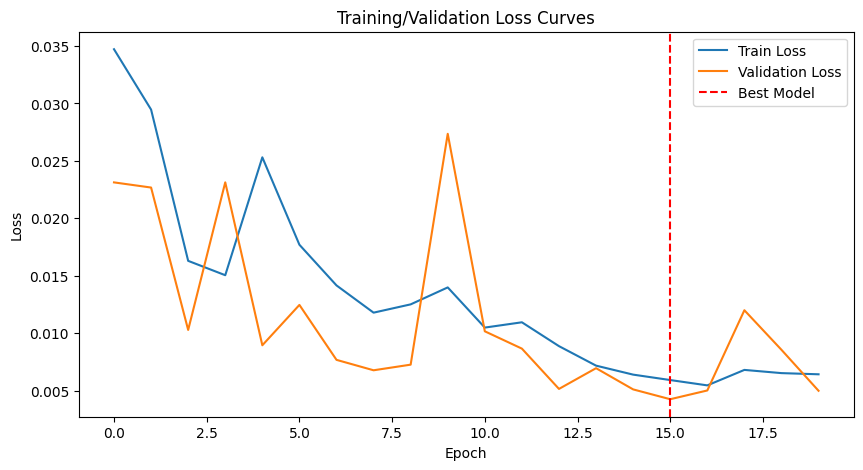

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt

# Fix seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Enhanced Loss Function
class StockLoss(nn.Module):
    def __init__(self, delta=0.5, direction_weight=0.6, margin=0.02):
        super().__init__()
        self.huber = nn.HuberLoss(delta=delta)
        self.direction_weight = direction_weight
        self.margin = margin
        
    def forward(self, preds, targets):
        # Base regression loss
        huber_loss = self.huber(preds, targets)
        
        # Directional loss only for multi-step predictions
        if preds.size(1) > 1:
            pred_dirs = preds[:, 1:] - preds[:, :-1]
            true_dirs = targets[:, 1:] - targets[:, :-1]
            
            # Only consider significant movements
            significant_moves = (true_dirs.abs() > self.margin).float()
            dir_accuracy = torch.sign(pred_dirs * true_dirs)
            
            # Loss for wrong directions on significant moves
            dir_loss = torch.mean(torch.relu(-dir_accuracy * significant_moves))
        else:
            dir_loss = torch.tensor(0.0, device=preds.device)
            
        return huber_loss + self.direction_weight * dir_loss




# Stronger regularization in optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)  # Increased weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
criterion = StockLoss(delta=0.5, direction_weight=0.6, margin=0.02).to(device)

best_val_loss = float('inf')
no_improve = 0
patience = 10
train_losses = []
val_losses = []
epochs = 30

for epoch in range(1, epochs + 1):
    model.train()
    epoch_train_losses = []
    
    # Data augmentation with Gaussian noise
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        if model.training:  # Only add noise during training
            # Add noise only to features, not to sequence length
            noise = torch.randn_like(batch_X) * 0.01
            batch_X = batch_X + noise
        
        optimizer.zero_grad()
        
        
        preds = model(batch_X)
        #print(preds.shape)
        loss = criterion(preds, batch_y.squeeze(-1))
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # Tighter clipping
        optimizer.step()
        
        epoch_train_losses.append(loss.item())


    
    # Validation
    losses = []
    all_preds = []
    all_targets = []
    for batch_X, batch_y in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        if model.training:  # Only add noise during training
            # Add noise only to features, not to sequence length
            noise = torch.randn_like(batch_X) * 0.01
            batch_X = batch_X + noise
        
        optimizer.zero_grad()
        
        # Forward pass
        preds = model(batch_X)
        all_preds.append(preds.squeeze(1).detach().cpu().numpy())
        all_targets.append(batch_y.squeeze(-1).detach().cpu().numpy())
        loss = criterion(preds, batch_y.squeeze(-1))
        losses.append(loss.item())
    avg_loss = np.mean(losses)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_loss=avg_loss
    val_rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    scheduler.step(val_loss)
    
    # Track losses
    avg_train_loss = np.mean(epoch_train_losses)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Val Loss={val_loss:.4f}, Val RMSE={val_rmse:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), "best_mamba_stock.pth")
        print("-> Saved Best Model")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

# Plot learning curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axvline(np.argmin(val_losses), color='r', linestyle='--', label='Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training/Validation Loss Curves')
plt.show()


Testing:   0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:999: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
Testing:  92%|█████████▏| 11/12 [00:00<00:00, 98.93it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:999: UserWarning: Using a target size (torch.Size([13, 1, 1])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
Testing: 100%|██████████| 12/12 [00:00<00:00, 98.68it/s]


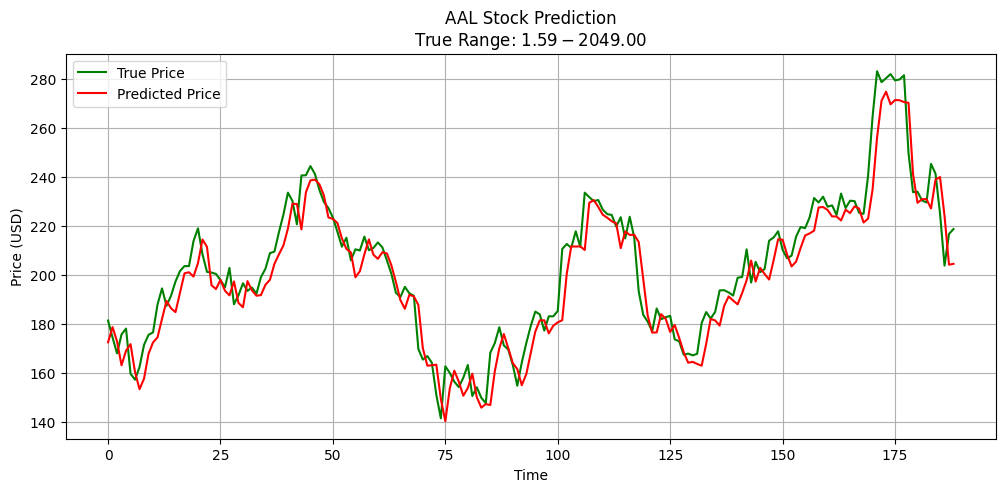


Normalized Metrics:
Test Loss: 0.0251
RMSE: 0.0926
MAE: 0.0709
R²: 0.8999
MAPE: 7.35%

Denormalized Metrics (USD):
RMSE: $9.26
MAE: $7.09
MAPE: 3.52%


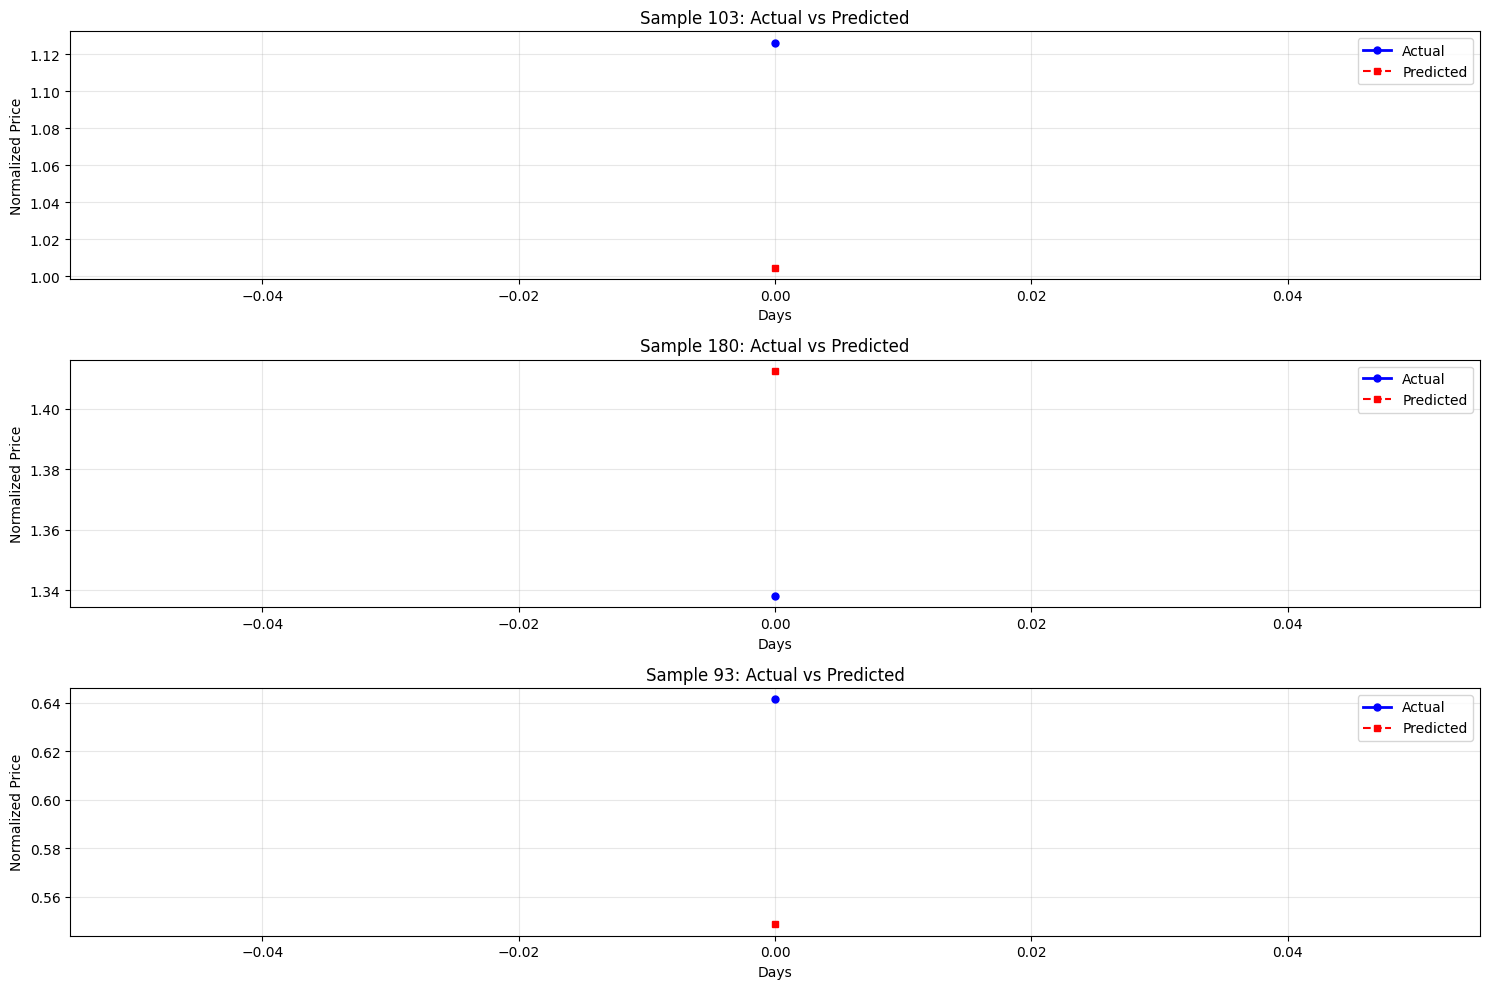

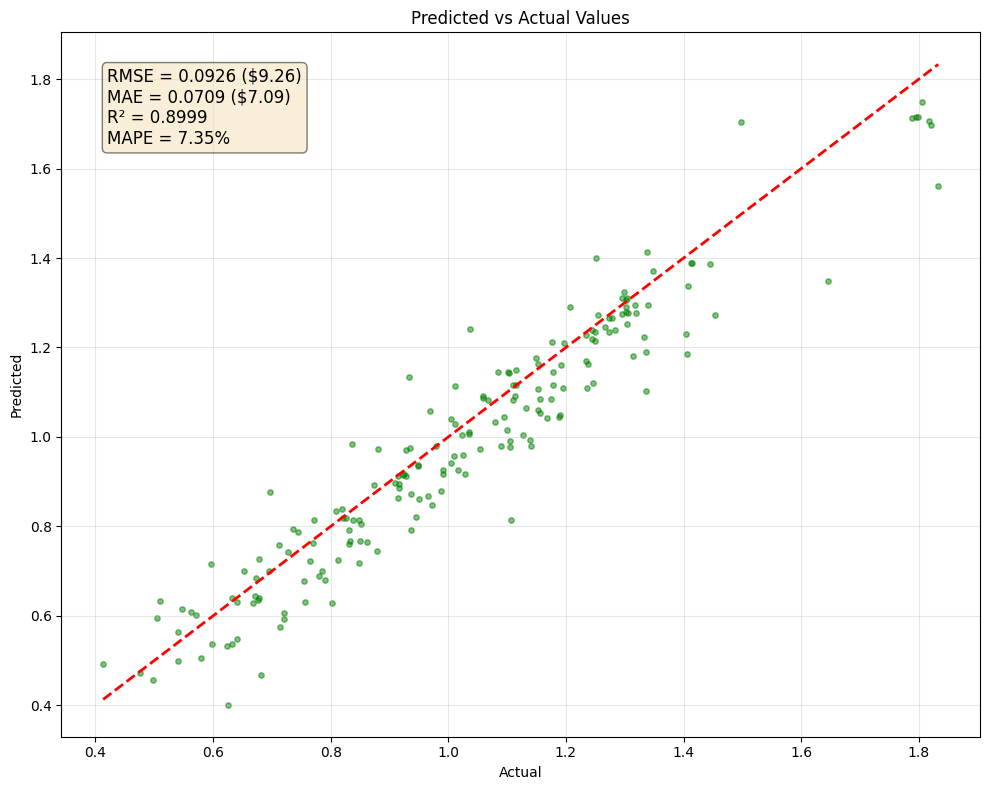

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


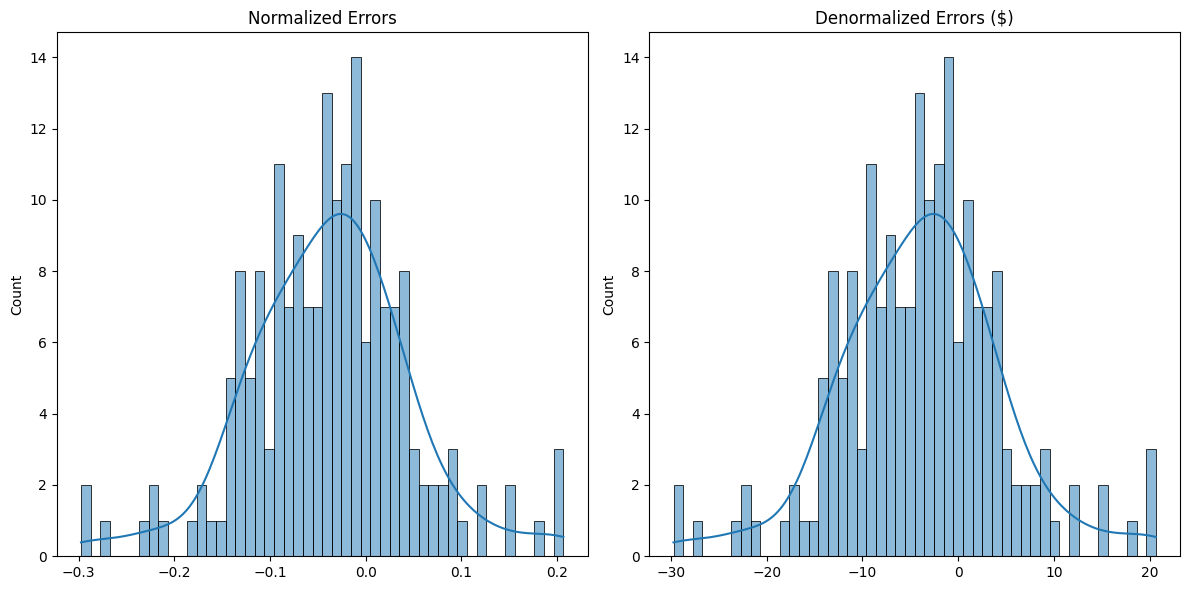

In [13]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import torch

# Assuming you have your scaler object saved during training
# If not, you'll need to recreate it with the original data range
# Example for MinMaxScaler (adjust if you used StandardScaler):
# scaler = MinMaxScaler()
# scaler.min_, scaler.scale_ = your_saved_min, your_saved_scale

# Define the loss function
criterion = StockLoss(delta=0.5, direction_weight=0.6, margin=0.02)

# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and ground truth
all_predictions = []
all_ground_truth = []

# Initialize total test loss
total_test_loss = 0

# Disable gradient calculation
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(tqdm(test_loader, desc="Testing")):
        # Move data to device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        
        predictions = model(x_batch)
        
        # Calculate loss
        loss = criterion(predictions, y_batch)
        total_test_loss += loss.item() * x_batch.size(0)
        
        # Store predictions and ground truth
        all_predictions.append(predictions.cpu().numpy())
        all_ground_truth.append(y_batch.cpu().numpy())

# Calculate average test loss
avg_test_loss = total_test_loss / len(test_loader.dataset)

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_ground_truth = np.concatenate(all_ground_truth, axis=0)

# Flatten for metrics calculation
y_true = all_ground_truth.flatten()
y_pred = all_predictions.flatten()

# Calculate metrics with error handling
try:
    # Normalized metrics
    # Calculate metrics with proper parenthesis balancing
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100

    # Denormalization example (replace with your actual scaler values)
    data_min = 100.0  # Minimum price in dataset
    data_max = 200.0  # Maximum price in dataset

    y_true_denorm = y_true * (data_max - data_min) + data_min
    y_pred_denorm = y_pred * (data_max - data_min) + data_min

    # Denormalized metrics
    rmse_denorm = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))
    mae_denorm = mean_absolute_error(y_true_denorm, y_pred_denorm)
    mape_denorm = np.mean(np.abs((y_true_denorm - y_pred_denorm) / np.maximum(np.abs(y_true_denorm), 1e-8))) * 100

      # Plotting with USD values
    plt.figure(figsize=(12, 5))
    plt.plot(y_true_denorm, label="True Price", color='green')
    plt.plot(y_pred_denorm, label="Predicted Price", color='red')
    plt.title(f"AAL Stock Prediction\nTrue Range: ${df['close'].min():.2f}-${df['close'].max():.2f}")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"\nNormalized Metrics:")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    print(f"\nDenormalized Metrics (USD):")
    print(f"RMSE: ${rmse_denorm:.2f}")
    print(f"MAE: ${mae_denorm:.2f}")
    print(f"MAPE: {mape_denorm:.2f}%")

except Exception as e:
    print(f"Error calculating metrics: {str(e)}")

# Visualization
try:
    # Plot 1: Time-series comparison
    plt.figure(figsize=(15, 10))
    for i in range(3):
        idx = np.random.randint(0, len(all_predictions))
        plt.subplot(3, 1, i+1)
        plt.plot(all_ground_truth[idx], 'b-o', label='Actual', linewidth=2, markersize=5)
        plt.plot(all_predictions[idx], 'r--s', label='Predicted', linewidth=1.5, markersize=5)
        plt.title(f"Sample {idx+1}: Actual vs Predicted")
        plt.xlabel("Days")
        plt.ylabel("Normalized Price")
        plt.grid(alpha=0.3)
        plt.legend()
    plt.tight_layout()
    plt.savefig('time_series_comparison.png', dpi=300)
    plt.show()

    # Plot 2: Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5, c='green', s=15)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', linewidth=2)
    plt.title("Predicted vs Actual Values")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(alpha=0.3)
    
    textstr = '\n'.join((
        f'RMSE = {rmse:.4f} (${rmse_denorm:.2f})',
        f'MAE = {mae:.4f} (${mae_denorm:.2f})',
        f'R² = {r2:.4f}',
        f'MAPE = {mape:.2f}%'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
                  fontsize=12, verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig('scatter_plot.png', dpi=300)
    plt.show()

    # Plot 3: Error distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    errors_norm = y_pred - y_true
    sns.histplot(errors_norm, kde=True, bins=50)
    plt.title('Normalized Errors')
    
    plt.subplot(1, 2, 2)
    errors_denorm = y_pred_denorm - y_true_denorm
    sns.histplot(errors_denorm, kde=True, bins=50)
    plt.title('Denormalized Errors ($)')
    
    plt.tight_layout()
    plt.savefig('error_distribution.png', dpi=300)
    plt.show()

except Exception as e:
    print(f"Error generating plots: {str(e)}")